# 定义一些可视化函数
`%matplotlib inline` 是 Jupyter Notebook 中的魔术命令之一，它用于指定在 notebook 中嵌入 matplotlib 绘图，并且在执行代码块后直接在 notebook 中显示图形输出，而不需要使用 `plt.show()` 函数。

具体而言：

- `%matplotlib` 是 Jupyter 中用于控制 matplotlib 图形的魔术命令。
- `inline` 表示要将图形嵌入到 notebook 中，而不是弹出一个新的窗口显示图形。

这使得在 notebook 中运行的代码块中生成的图形能够直接显示在代码块下方，而无需额外的显示命令。这对于数据可视化和图形分析来说非常方便。

In [31]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

# Data Prepare

In [32]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
# path = osp.join(osp.dirname(osp.realpath('Planetoid')), 'data', 'Planetoid')
path = osp.join(osp.dirname(osp.realpath('GNNExplainer.ipynb')), '.', 'data', 'Planetoid')
print('dataset path:', path)
dataset = Planetoid(path, dataset)
data = dataset[0]

dataset path: /harddisk/hd/Project/PyCharm/PaperCode/myGNN/./data/Planetoid


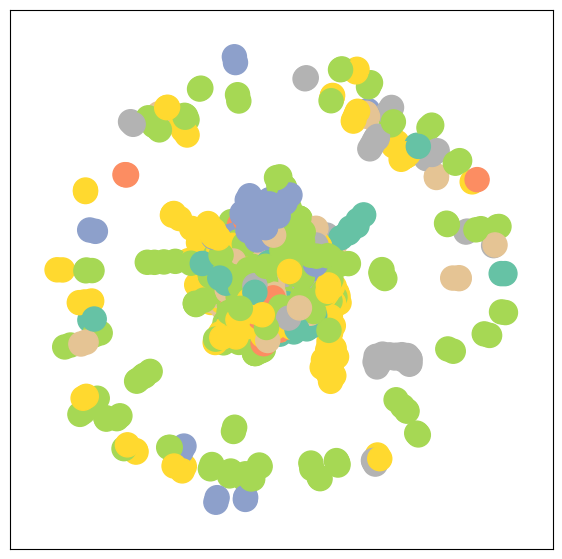

In [33]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# 定义网络模型

In [34]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 训练

In [35]:
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}, loss: {}'.format(epoch, loss))

epoch: 10, loss: 0.882247269153595
epoch: 20, loss: 0.3016943633556366
epoch: 30, loss: 0.1567929983139038
epoch: 40, loss: 0.06808847934007645
epoch: 50, loss: 0.05264759436249733
epoch: 60, loss: 0.039165206253528595
epoch: 70, loss: 0.03457961603999138
epoch: 80, loss: 0.029717177152633667
epoch: 90, loss: 0.046043798327445984
epoch: 100, loss: 0.02525787614285946
epoch: 110, loss: 0.03851279243826866
epoch: 120, loss: 0.055582404136657715
epoch: 130, loss: 0.029353046789765358
epoch: 140, loss: 0.03561699017882347
epoch: 150, loss: 0.030785169452428818
epoch: 160, loss: 0.03481220081448555
epoch: 170, loss: 0.030572107061743736
epoch: 180, loss: 0.02385495975613594
epoch: 190, loss: 0.03151225671172142
epoch: 200, loss: 0.025863347575068474
epoch: 210, loss: 0.01903608627617359
epoch: 220, loss: 0.020894259214401245
epoch: 230, loss: 0.028966542333364487
epoch: 240, loss: 0.033569566905498505
epoch: 250, loss: 0.02136138081550598
epoch: 260, loss: 0.016017496585845947
epoch: 270, l

# 解释器

In [38]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = './explanations/feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = './explanations/subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to './explanations/feature_importance.png'
Subgraph visualization plot has been saved to './explanations/subgraph.pdf'
